In [12]:
import argparse
from argparse import Namespace
import os, sys, glob, json, pathlib, shutil, math
import numpy as np
import pandas as pd

import scipy
from scipy.io import loadmat
from scipy import  signal
import matplotlib.pyplot as plt
import nibabel as nib
import SimpleITK as sitk

# https://stackoverflow.com/questions/52980565/arranging-widgets-in-ipywidgets-interactive
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'

#importing the necessary items from the Ipywidgets library
import ipywidgets as widgets
from ipywidgets import interactive,interact, interact_manual, HBox, Layout,VBox
from IPython.display import display, clear_output

from viu.io.volume import read_volume

from exampleUtils import *

/var/tmp/ipykernel_966831/1169526780.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [14]:
def convert_binId_to_workingVolId(vol_idx_msk, binId):
    print(f'binId {binId}')
    assert vol_idx_msk[binId], f'Bin {binId} is not loaded.'
    aList = [id for id in range(len(vol_idx_msk)) if vol_idx_msk[id]==True and id <= binId]
    print(f'aList {aList}')
    workingVolId = len([id for id in range(len(vol_idx_msk)) if vol_idx_msk[id]==True and id <= binId]) -1
    print(f'workingVolId {workingVolId}')
    return workingVolId

def convert_workingVolId_to_binId(vol_idx_msk, vols, workingVolId):
    print(f'workingVolId {workingVolId}')
    aList = [id for id in range(len(vol_idx_msk)) if vol_idx_msk[id]==True]
    print(f'aList {aList}')
    len_vols = len(aList)
    assert workingVolId  in range(len(vols)), f'workingVolId {workingVolId} is not in range({len_vols})'
    binId = [id for id in range(len(vol_idx_msk)) if vol_idx_msk[id]==True][workingVolId]
    print(f'binId {binId}')
    return binId


In [3]:
# #Previous code with skip
# workingFolderParent = '/home/wd974888/Downloads'
# logFilepath = f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/log.txt'
# patiendId = 4 #in range(8,9): #range(1,12) #range(1,12) #Use <truncateDepth_initial, final> : Pat01:<50, 50>; Pat02:<50, 50>; Pat04:<0, 0>; Pat07:<95, 95>; Pat09:<200, 100>;
# binningType = 'PB' # in ['AB']: #['AB', 'PB']
# patientMRN = f'Patient{patiendId:02d}{binningType}'
# print(f'patientMRN {patientMRN}')
# args =  Namespace(\
#     vol=f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/{patientMRN}/StudyAnonymized/bin*',\
#     pca_fn=f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/{patientMRN}/{patientMRN}_test_pca.hdf',\
#     dvfs=None,\
#     cache_dvf_npz_folder=f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/{patientMRN}/DVFStore/',\
#     vols_fn=f'{patientMRN}_test_vols.hdf',\
#     cache=f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/{patientMRN}/Cache/',\
#     body_seg=True,\
#     body_seg_union=True,\
#     nifti_body_seg='seg/body.nii.gz',\
#     air_threshold=-300,\
#     skip=1,\
#     skip_idx=None,\
#     deferred_resampling=True,\
#     force_pca=True,\
#     plot=True,\
#     reconstructedVol_fn=f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/{patientMRN}/{patientMRN}_reconstructed_vols.hdf',\
#     mean2dcm=True,\
#     dirOptionsDict_fn=f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/dirOptionsDict.json',\
#     fps=4,\
#     prefilter=False,\
#     truncateDepth_initial=0,\
#     truncateDepth_final=0\
#     )
# print(args)

In [4]:
# #Previous code with skip
# from viu.io.volume import read_volume
# vols = None
# msks = None
# #First read the volumes
# if vols is None:
#     vol_fnl = glob(args.vol)
#     vol_fnl = sort_by_series_number(vol_fnl)

#     vol_idx_msk = torch.ones(len(vol_fnl), dtype=bool)
#     if args.skip > 0:
#         vol_idx_msk[torch.arange(len(vol_idx_msk)) % (args.skip + 1) != 0] = False

#     if args.skip_idx is not None:
#         for i in args.skip_idx:
#             vol_idx_msk[i] = False

#     vol_fnl = [vol_fnl[i] for i, b in enumerate(vol_idx_msk) if b]

#     #########
#     tmp_vol, _, _ = read_volume(vol_fnl[0])
#     org_depth=tmp_vol.shape[0]
#     startSlice=args.truncateDepth_initial
#     endSlice=org_depth - args.truncateDepth_final
#     new_depth = org_depth - args.truncateDepth_initial - args.truncateDepth_final
#     print(f'org_depth {org_depth} startSlice {startSlice} endSlice {endSlice} new_depth {new_depth}')
#     #########
#     vol_lst = []
#     for vfn in vol_fnl:
#         print(f'Loading {vfn}...')
#         vol, res, pos = read_volume(vfn)
#         ######
#         vol=vol[startSlice:endSlice, ...]
#         ######
#         vol_lst.append(torch.Tensor(vol)[None, ...])
#     vols = torch.concatenate(vol_lst, dim=0)
#     del vol_lst

# #Then  get the body mask of each scans and if needed generate mask by segmentation
# vol_min = -1200
# cnt = vols.shape[0]
# dst_dim = torch.tensor(vols[0].squeeze().shape[::-1])
# dst_res = torch.tensor(res, dtype=torch.float64)
# msk_lst = []
# if args.body_seg:
#     for i in range(cnt):
#         #Mask is always obtained on the untruncated volume and then truncated as trying to obtain mask on truncated volume is giving empty mask!!!
#         if args.nifti_body_seg is not None:
#             fn = os.path.join(vol_fnl[i], args.nifti_body_seg)
#             print(f'Load body segmentation: {fn}...')
#             ####
#             # msk = torch.tensor(nib.load(fn).get_fdata()).to(bool).permute(2, 1, 0).flip(1)[None, ...]
#             # Truncate as needed
#             msk = torch.tensor(nib.load(fn).get_fdata()).to(bool).permute(2, 1, 0).flip(1)[startSlice:endSlice, ...][None, ...]
#             ####
#         else:
#             print('Find connected components...')
#             msk = torch.tensor(seg_body(vols[(i + 1) % cnt], args.air_threshold, air_dilation=4))
#         print(f'msk shape {msk.shape}')
#         msk_lst.append(msk)
#     msks = torch.concatenate(msk_lst, dim=0)
#     del msk_lst

#     if args.body_seg_union:
#         msks = reduce(lambda a, b: a.bitwise_or(b), msks)[None, ...]
#         # hack to fill disconnected air components at the volume borders
#         from skimage import measure
#         label = measure.label(torch.bitwise_not(msks).numpy())
#         idx, label_cnt = np.unique(label, return_counts=True)
#         idx = idx[np.argsort(label_cnt)[:-1]]
#         for i in idx:
#             #Exception in PyTorch 2.2 env: IndexError: The shape of the mask [1, 590, 512, 512] at index 0 does not match the shape of the indexed tensor [590, 512, 512] at index 0
#             #Because msks[0].shape = [590, 512, 512], But [label == i].shape = [1, 590, 512, 512]
#             msk[0][label == i] = True #Replaced [0] to remove exception in Baden environment #msks[0][label == i] = True
#         # ---

In [5]:
# #Previous code with skip
# working_vol_id_fproject=4
# display_vol = vols[working_vol_id_fproject,...].cpu().numpy()
# print(f'display_vol shape {display_vol.shape} type {type(display_vol)} dtype {display_vol.dtype}')
# print(f'pos value {pos} dtype {pos.dtype}')
# print(f'res value {res} dtype {res.dtype}')
# binId=convert_workingVolId_to_binId(vol_idx_msk, working_vol_id_fproject)

In [15]:
#Use <truncateDepth_initial, final> : Pat01:<50, 50>; Pat02:<50, 50>; Pat04:<0, 0>; Pat07:<95, 95>; Pat09:<200, 100> to match generated PCAs if using preFilter
workingFolderParent = '/home/wd974888/Downloads'
patiendId = 4
binningType = 'PB'
patientMRN = f'Patient{patiendId:02d}{binningType}'
print(f'patientMRN {patientMRN}')
truncateDepth_initial=0
truncateDepth_final=0
volFolder=f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/{patientMRN}/StudyAnonymized/bin*'
vol_fnl = glob(volFolder)
vol_fnl = sort_by_series_number(vol_fnl)

#Truncation calculation
tmp_vol, _, _ = read_volume(vol_fnl[0])
org_depth=tmp_vol.shape[0]
startSlice=truncateDepth_initial
endSlice=org_depth - truncateDepth_final
new_depth = org_depth - truncateDepth_initial - truncateDepth_final
print(f'org_depth {org_depth} startSlice {startSlice} endSlice {endSlice} new_depth {new_depth}')

#########
vol_lst = []
for vfn in vol_fnl:
    print(f'Loading {vfn}...')
    vol, res, pos = read_volume(vfn)
    ######
    vol=vol[startSlice:endSlice, ...]
    ######
    vol_lst.append(torch.Tensor(vol)[None, ...])
vols = torch.concatenate(vol_lst, dim=0)
del vol_lst

#Display one bin
binId=0
display_vol = vols[binId,...].cpu().numpy()
print(f'display_vol shape {display_vol.shape} type {type(display_vol)} dtype {display_vol.dtype}')
print(f'pos value {pos} dtype {pos.dtype}')
print(f'res value {res} dtype {res.dtype}')

v1_volumeComparisonViewer3D(
    listVolumes=[display_vol],listLabels=[f'{patientMRN}_bin_{binId:02d}'],
    maxZ0=display_vol.shape[0], maxZ1=display_vol.shape[1], maxZ2=display_vol.shape[2],
    figsize=(12,8), cmap='gray',
    displayColorbar=False, useExternalWindowCenter=True, wMin=-500, wMax=500, useAspectCol=False)

patientMRN Patient04PB
org_depth 210 startSlice 0 endSlice 210 new_depth 210
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient04PB/StudyAnonymized/bin_01...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient04PB/StudyAnonymized/bin_02...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient04PB/StudyAnonymized/bin_03...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient04PB/StudyAnonymized/bin_04...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient04PB/StudyAnonymized/bin_05...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient04PB/StudyAnonymized/bin_06...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient04PB/StudyAnonymized/bin_07...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient04PB/StudyAnonymized/bin_08...
Loading /home/wd974888/Downloads/wo

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [16]:
#Generate projections
# Common params
angleList= list(range(0, 359,20))
angles = np.array(angleList, 'float32')
num_proj=len(angles)
print(f'num_proj {num_proj} angles {angles}')
writeProjectionsInHD5File=True
srcPos_mm=(0.0, 0.0, 1000)
detPos_mm=(0.0, 0.0, -500) 
prjSize_pixels=(1024, 768)
prjRes_mm=(0.388, 0.388)
scan_velocity_degPersec_int=6
boneHU = 250 #Use this to multiply binary (0-1) segmented bone volume
vol_center_XYZ_mm = (0.0, 0.0, 0.0) #np.array(, 'float32'), #ctVol center
iso_center_XYZ_mm = (0.0, 0.0, 0.0) #np.array(, 'float32'), #planning isocenter in CT volume
hu_offset=-1000
hu_max=400
hu_slope=50000

projectionsAlreadyCreated=True
if not projectionsAlreadyCreated:
        for binId in range(len(vols)):
                projection_out_file = f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/{patientMRN}/projections_bin_{binId:02d}.hdf'
                print(f'projection_out_file: {projection_out_file}')
                vol_data_ZYX=vols[binId,...].cpu().numpy()
                vol_pos_XYZ_mm=pos.astype('float32')
                vol_res_XYZ_mm=res.astype('float32')
                print(f'binId {binId} vol_data_ZYX min {np.min(vol_data_ZYX)} max {np.max(vol_data_ZYX)} pos_XYZ {vol_pos_XYZ_mm} res_XYZ {vol_res_XYZ_mm}')
                #Project CT volumes and save result and display
                ctVol_projs = generateForwardProjections(
                        vol_data_ZYX=vol_data_ZYX,
                        vol_res_XYZ_mm = vol_res_XYZ_mm,
                        vol_pos_XYZ_mm = vol_pos_XYZ_mm,
                        iso_pos_XYZ_mm = vol_pos_XYZ_mm, #Using volume center as isocenter
                        alreadyNormalizedFlag=False,
                        hu_offset=hu_offset,
                        hu_max=hu_max,
                        hu_slope=hu_slope,
                        proj_angles_degrees=angles,
                        srcPos_mm=srcPos_mm,
                        detPos_mm=detPos_mm,
                        prjSize_pixels=prjSize_pixels,
                        prjRes_mm=prjRes_mm,
                        scan_velocity_degPersec_int=scan_velocity_degPersec_int,
                        writeProjectionsInHD5File=writeProjectionsInHD5File,
                        projectionFileName=projection_out_file,
                        debugFlag=True
                        )
                print(f'ctVol_projs.shape {ctVol_projs.shape}')

num_proj 18 angles [  0.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.
 280. 300. 320. 340.]


In [17]:
#Read projections from hdf file.
working_binId = 5
projection_file_path = f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/{patientMRN}/projections_bin_{working_binId:02d}.hdf'
ctVol_projs = np.zeros((num_proj, prjSize_pixels[1], prjSize_pixels[0]), dtype='float32')
with h5py.File(projection_file_path, 'r') as F:
    for p in range(num_proj):
        pname="Projection"+f'{p:05}'+'/'+"AttenuationImage1"
        proj=F[pname][()]
        print(f'{pname} : {proj.shape}')
        ctVol_projs[p,...]=proj
print(f'ctVol_projs shape {ctVol_projs.shape} dtype {ctVol_projs.dtype}')

Projection00000/AttenuationImage1 : (768, 1024)
Projection00001/AttenuationImage1 : (768, 1024)
Projection00002/AttenuationImage1 : (768, 1024)
Projection00003/AttenuationImage1 : (768, 1024)
Projection00004/AttenuationImage1 : (768, 1024)
Projection00005/AttenuationImage1 : (768, 1024)
Projection00006/AttenuationImage1 : (768, 1024)
Projection00007/AttenuationImage1 : (768, 1024)
Projection00008/AttenuationImage1 : (768, 1024)
Projection00009/AttenuationImage1 : (768, 1024)
Projection00010/AttenuationImage1 : (768, 1024)
Projection00011/AttenuationImage1 : (768, 1024)
Projection00012/AttenuationImage1 : (768, 1024)
Projection00013/AttenuationImage1 : (768, 1024)
Projection00014/AttenuationImage1 : (768, 1024)
Projection00015/AttenuationImage1 : (768, 1024)
Projection00016/AttenuationImage1 : (768, 1024)
Projection00017/AttenuationImage1 : (768, 1024)
ctVol_projs shape (18, 768, 1024) dtype float32


numDisplayCols 4
int_division_result 4
numDisplayRows 5
count 17 angle 340.0row 4 col 2


Text(0.5, 0.98, 'Patient04PB_binId_05 projections')

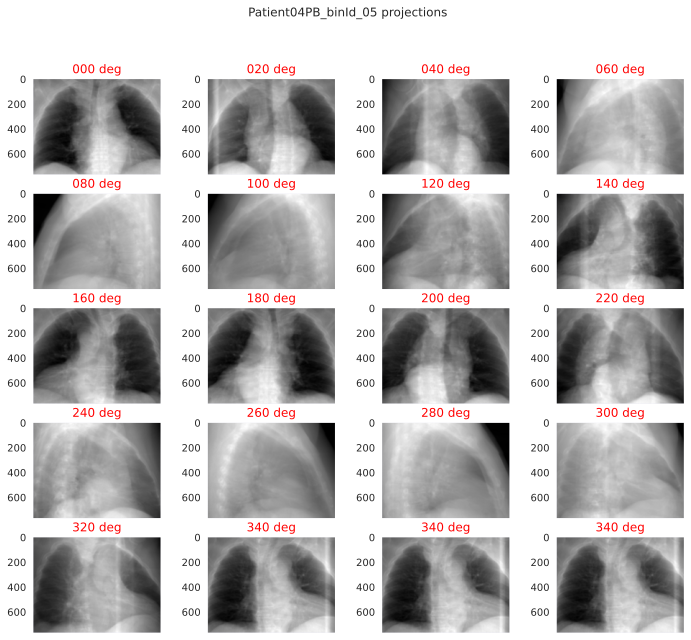

In [20]:
#Display projections
# #Read projections from hdf file.
# working_binId = 5
# projection_file_path = f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/{patientMRN}/projections_bin_{working_binId:02d}.hdf'
# with h5py.File(projection_file_path, 'r') as F:
#     ctVol_projs = F["Projection"][:]
# numAnglesFromProj = ctVol_projs.shape[0]
# num_proj=len(angles)
# assert numAnglesFromProj == num_proj, f'Mismatch numAnglesFromProj {numAnglesFromProj} num_proj {num_proj}'
# print(f'num_proj {num_proj}')
numDisplayCols=4
print(f'numDisplayCols {numDisplayCols}')
int_division_result = num_proj//numDisplayCols
print(f'int_division_result {int_division_result}')
numDisplayRows= int_division_result if num_proj%numDisplayCols==0 else int_division_result+1
print(f'numDisplayRows {numDisplayRows}')
img_fig, img_axes = plt.subplots(numDisplayRows, numDisplayCols, figsize=(12,2.5*numDisplayCols)) #, gridspec_kw={'width_ratios': [1, 3, 3, 3]}
row,col=0,0
for count, angle in enumerate(angles.tolist()): #proj
    img_axes[row,col].imshow(ctVol_projs[count,:,:], alpha=1.0, cmap=plt.get_cmap('gray'))
    img_axes[row,col].set_title(f'{round(angle):03d} deg', fontdict={'color': 'r'})
    img_axes[row,col].grid(False)
    img_axes[row,col].set_xticks([])
    col=col+1
    if col%numDisplayCols==0:
        col=0
        row=row+1
print(f'count {count} angle {angle}row {row} col {col}')
#In case number of projections is not divisible by numDisplayCols
if col > 0: #num_proj%numDisplayCols !=0:
    while col < numDisplayCols:
        img_axes[row,col].imshow(ctVol_projs[count,:,:], alpha=1.0, cmap=plt.get_cmap('gray'))
        img_axes[row,col].set_title(f'{round(angle):03d} deg', fontdict={'color': 'r'})
        img_axes[row,col].set_xticks([])
        img_axes[row,col].grid(False)
        col=col+1

img_fig.suptitle(f'{patientMRN}_binId_{working_binId:02d} projections')

In [ ]:
# #Display CT projection
# f,ax = plt.subplots(1,len(ctVol_projs), squeeze=False, figsize=(12.0, 8.0))
# row=0
# for col in range(len(ctVol_projs)):
#     ax[row,col].grid(False)
#     ax[row,col].imshow(ctVol_projs[col,...], cmap=plt.get_cmap('gray'), vmin=np.min(ctVol_projs[col,...]), vmax=np.max(ctVol_projs[col,...]))
# plt.axis("scaled")
# plt.show()
